In [2]:
from IPython.display import display
import numpy as np
import pandas as pd
import mxfusion as mf
import mxnet as mx
from scipy.io import loadmat
import matplotlib.pyplot as plt
from sklearn.decomposition import DictionaryLearning, MiniBatchDictionaryLearning
from sklearn.preprocessing import StandardScaler
import seaborn as sns
sns.set_context('talk')
sns.set_style('darkgrid')

/usr/local/Cellar/python/3.6.5/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/local/Cellar/python/3.6.5/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [3]:
# Plotting functions
def plot_reconstruction(ax1, ax2, x, r, z):
    ax1.plot(range(len(x)), x, range(len(x)), r)
    ax1.legend(["original", "reconstruction"])
    ax1.set_title(f'Reconstrunction error {np.sqrt(np.linalg.norm(x - r)):.3f}')
    ax2.stem(range(len(z)), z)
    ax2.set_ylim([-0.1, 0.1])

(7802, 150)
(7802, 1)


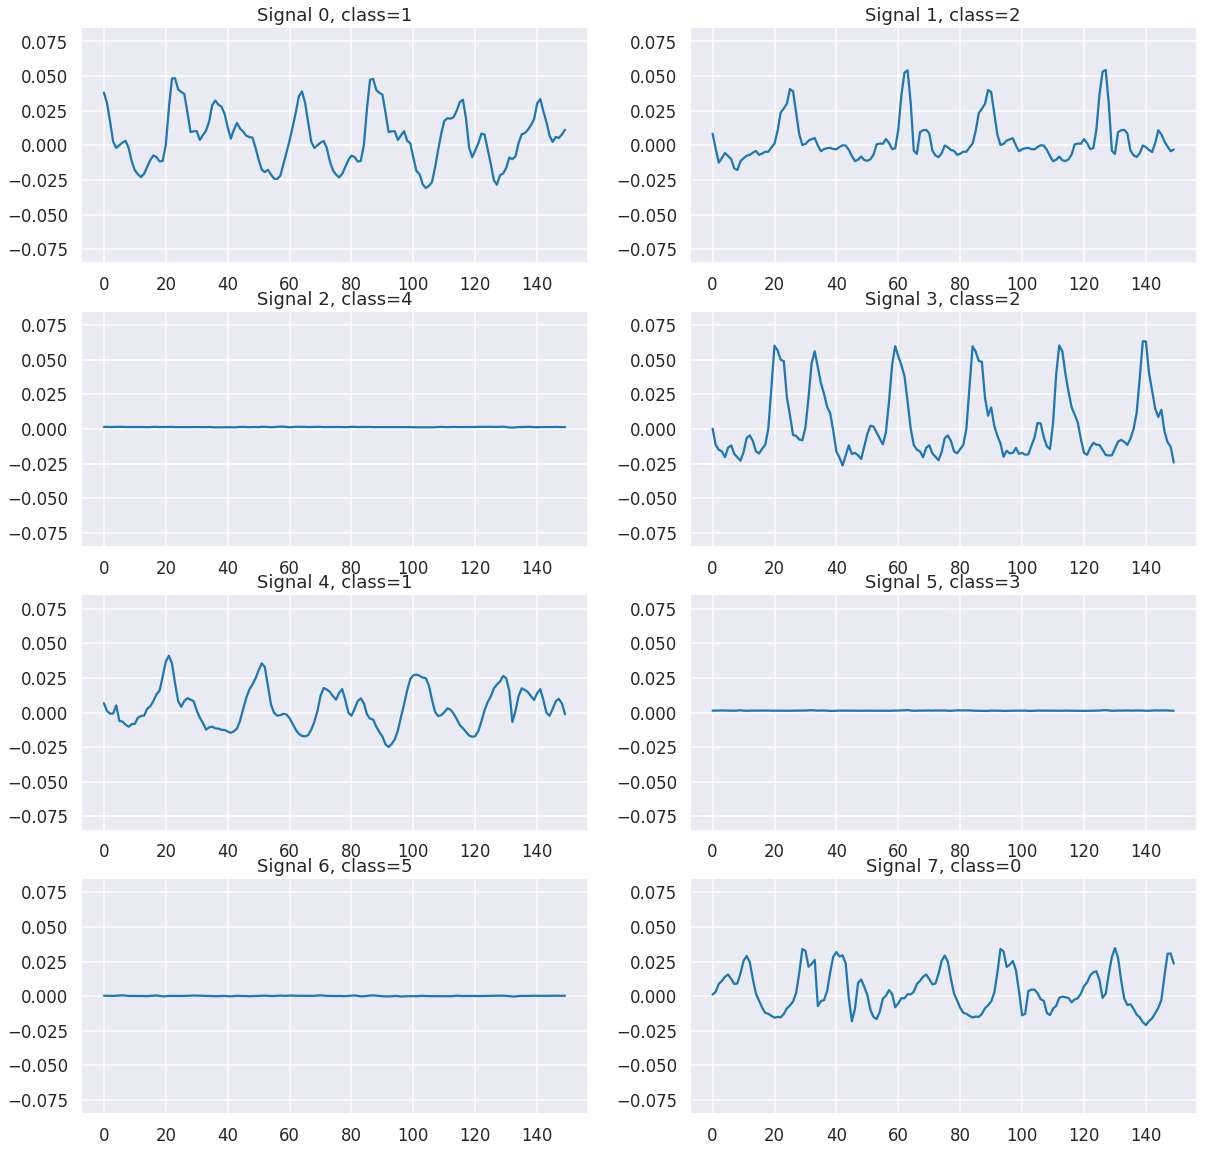

In [4]:
data = loadmat('accelerometer_data.mat')
x_train = data['train_x']
y_train = data['train_y'].T
x_test = data['test_x']
y_test = data['test_y'].T
[m_train, n] = x_train.shape
m_test = x_test.shape[0]
print(x_train.shape)
print(y_train.shape)

# Standardize data
# scaler = StandardScaler().fit(x_train)
# x_train = scaler.fit_transform(x_train)
# x_test = scaler.transform(x_test)

norms = np.linalg.norm(x_train, axis=0)
x_train = x_train / norms
x_test = x_test / norms

minmax = np.max(np.abs(x_train))

fig, axs = plt.subplots(4, 2, figsize=(20, 20))
axs = axs.flatten()
for i in range(len(axs)):
    sns.lineplot(ax=axs[i], data=x_train[i, :])
    # sns.lineplot(ax=axs[i], data=D[i, :])
    axs[i].set_ylim([-minmax, minmax])
    axs[i].set_title(f'Signal {i}, class={y_train[i, 0]}')
    
df_train = pd.DataFrame(np.hstack([x_train, y_train]), columns=tuple(map(str, range(x_train.shape[1]))) + ('y',))
# display(df_train.head())
df1_train = df_train[df_train['y'] == 1].drop('y', inplace=False, axis=1)
# display(df1_train.head())

df_test = pd.DataFrame(np.hstack([x_test, y_test]), columns=tuple(map(str, range(x_test.shape[1]))) + ('y',))
# display(df_test.head())
df1_test = df_test[df_test['y'] == 1].drop('y', inplace=False, axis=1)
# display(df1_test.head())

In [5]:
k = 256
dico = MiniBatchDictionaryLearning(n_components=k, alpha=0.1, n_iter=500)
# dico = DictionaryLearning(n_components=k, alpha=0.1)
D = dico.fit(df1_train).components_

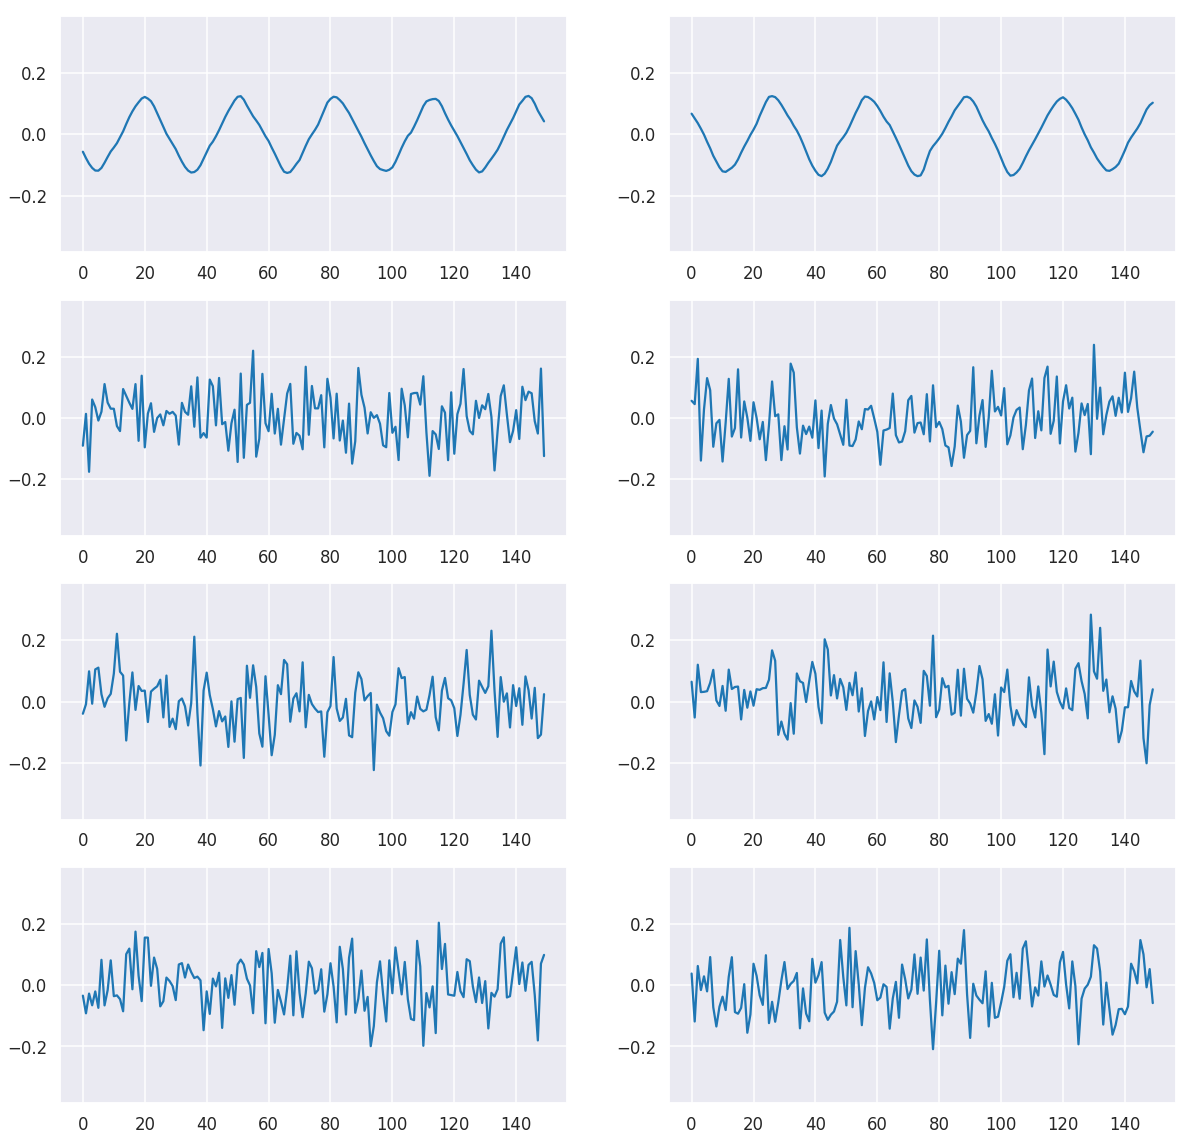

In [6]:
# Print some of the bases
dminmax = np.max(np.abs(D))
fig, axs = plt.subplots(4, 2, figsize=(20, 20))
axs = axs.flatten()
for i in range(len(axs)):
    sns.lineplot(ax=axs[i], data=D[i, :])
    axs[i].set_ylim([-dminmax, dminmax])

In [7]:
# Reconstruct it frame-by-frame using a linear combination of 20 atoms per frame (sparsity-constrained OMP)
from sklearn.decomposition import SparseCoder
coder = SparseCoder(dictionary=D, transform_n_nonzero_coefs=20, transform_alpha=None, transform_algorithm="omp")
Z = coder.transform(df1_test)
reconstructions = np.dot(Z, D)

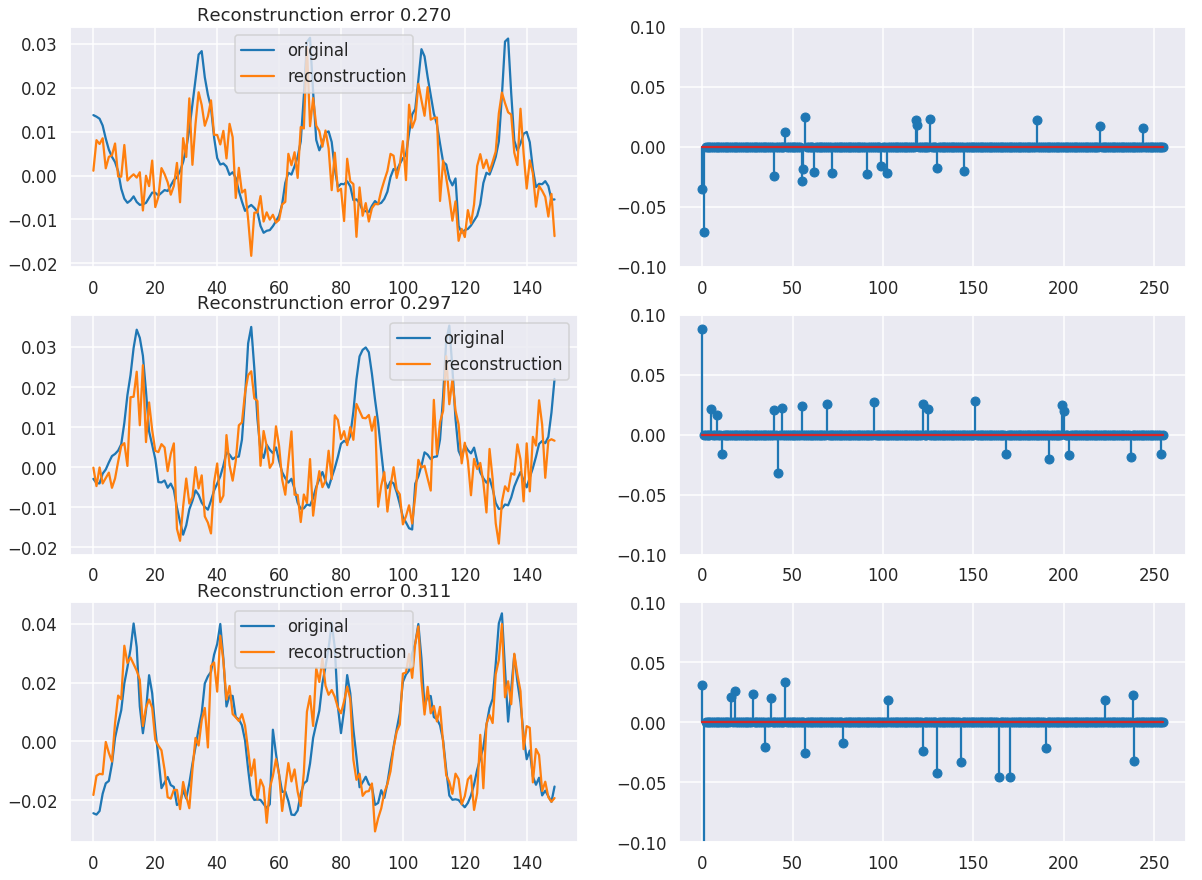

In [8]:
# Plot a couple of reconstructions along with the coefficient vectors
idxs = [0, 10, 100]

fig, axs = plt.subplots(len(idxs), 2, figsize=(20, 5 * len(idxs)))
axs = axs.flatten()

for i, idx in enumerate(idxs):
    plot_reconstruction(axs[2 * i], axs[2 * i + 1], df1_test.values[idx, :], reconstructions[idx, :], Z[idx, :])

In [11]:
# MXFusion model
from mxfusion import Model, Variable
from mxfusion.components.distributions import Normal, MultivariateNormal, Laplace
from mxfusion.components.functions.operators import dot
from mxfusion.components.variables import PositiveTransformation
from mxfusion.components.functions import MXFusionGluonFunction
from mxfusion.components.functions.operators import broadcast_to

X = mx.nd.array(df1_train.to_dense())

k = 256
[m, n] = df1_train.values.shape
print(f"m: {m}, n: {n}, k: {k}")

zero = mx.nd.array([0])
one = mx.nd.array([1])
model = Model()

sizes_as_variables = False
full_covariance = False

if sizes_as_variables:
    model.n = Variable()
    model.k = Variable()
    model.m = Variable()
else:
    model.n = n
    model.k = k
    model.m = m
    
D_init = mx.nd.random_normal(shape=(k, n))

# if full_covariance:
#     cov = broadcast_to(mx.nd.expand_dims(mx.nd.array(np.eye(model.k)), 0), shape=(model.m, model.k, model.k))
#     model.Z = MultivariateNormal.define_variable(mean=mx.nd.zeros(shape=(model.m, model.k)), covariance=cov, shape=(model.m, model.k))
# else:
#     model.Z = Normal.define_variable(mean=broadcast_to(zero, (model.m, model.k)), variance=broadcast_to(one, (model.m, model.k)), shape=(model.m, model.k))  

model.Z = Laplace.define_variable(location=broadcast_to(zero, (model.m, model.k)), scale=broadcast_to(one, (model.m, model.k)), shape=(model.m, model.k))  
model.D = Normal.define_variable(mean=broadcast_to(zero, (model.k, model.n)), variance=broadcast_to(one, (model.k, model.n)), shape=(model.k, model.n))
sigma_2 = Variable(shape=(1,), transformation=PositiveTransformation())
model.X = Normal.define_variable(mean=dot(model.Z, model.D), variance=broadcast_to(sigma_2, (model.m, model.n)), shape=(model.m, model.n))

print(model)

# Monkey patch modified factor printing
from mxfusion.components import Factor
def print_factor(self):
    out_str = self.__class__.__name__
    if self.predecessors is not None:
        out_str += '(' + ', '.join([str(name) + '=' + str(var) for name, var in self.predecessors]) \
                   + (f", shape={self.outputs[0][1].shape})" if len(self.outputs) == 1 else ')')
    return out_str
Factor.__repr__ = print_factor

print(model)

m: 1250, n: 150, k: 256
Model (800d6)
Variable (6cfe8) = BroadcastToOperator(data=Variable (80795))
Variable (c461d) = BroadcastToOperator(data=Variable (7e2dd))
Variable (74f82) = BroadcastToOperator(data=Variable (d598e))
Variable D (0d59f) ~ Normal(mean=Variable (74f82), variance=Variable (c461d))
Variable (ecbdd) = BroadcastToOperator(data=Variable (3279f))
Variable (c3880) = BroadcastToOperator(data=Variable (99995))
Variable Z (a3e85) ~ Laplace(location=Variable (c3880), scale=Variable (ecbdd))
Variable (0d45b) = CustomOperator(x=Variable Z (a3e85), y=Variable D (0d59f))
Variable X (c5701) ~ Normal(mean=Variable (0d45b), variance=Variable (6cfe8))
Model (800d6)
Variable (6cfe8) = BroadcastToOperator(data=Variable (80795), shape=(1,))
Variable (c461d) = BroadcastToOperator(data=Variable (7e2dd), shape=(1,))
Variable (74f82) = BroadcastToOperator(data=Variable (d598e), shape=(1,))
Variable D (0d59f) ~ Normal(mean=Variable (74f82), variance=Variable (c461d), shape=(256, 150))
Variab

In [28]:
from mxfusion.inference import StochasticVariationalInference
from mxfusion.inference.grad_based_inference import GradBasedInference
from mxfusion.inference import BatchInferenceLoop
from mxfusion.inference.meanfield import create_Gaussian_meanfield
from mxfusion.models import Model, Posterior
from mxfusion.components.variables import VariableType
from mxfusion.util.inference import variables_to_UUID

obs = [('X', X)]
if sizes_as_variables:
    obs += [('m', mx.nd.array([m])), ('k', mx.nd.array([k])), ('n', mx.nd.array([n]))]
observed = [getattr(model, x[0]) for x in obs]

q = Posterior(model)
q[model.Z].set_prior(Laplace(location=Variable(shape=model.Z.shape), 
                             scale=Variable(shape=model.Z.shape, transformation=PositiveTransformation())))
q[model.D].set_prior(Normal(mean=Variable(shape=model.D.shape),
                            variance=Variable(shape=model.D.shape, transformation=PositiveTransformation())))

print(model.X.shape)

svi = StochasticVariationalInference(model=model, num_samples=10, observed=observed, posterior=q)
infr = GradBasedInference(inference_algorithm=svi, grad_loop=BatchInferenceLoop())
infr.run(**dict(obs), max_iter=100)

(1250, 150)


/Users/tdiethe/code/MXFusion/examples/notebooks/mxfusion/inference/inference_parameters.py:74: UserWarning: InferenceParameters has already been initialized.  The existing one will be overwritten.
  warnings.warn("InferenceParameters has already been initialized.  The existing one will be overwritten.")


In [29]:
from mxfusion.inference import VariationalPosteriorForwardSampling

infr2 = VariationalPosteriorForwardSampling(10, observed, infr, target_variables=[model.D, model.Z])
res = infr2.run(**dict(obs))

/Users/tdiethe/code/MXFusion/examples/notebooks/mxfusion/models/factor_graph.py:87: UserWarning: The value Variable X (c5701) has already been assigned in the model.
  warnings.warn("The value {} has already been assigned in the model.".format(str(value)))
/Users/tdiethe/code/MXFusion/examples/notebooks/mxfusion/inference/inference_parameters.py:74: UserWarning: InferenceParameters has already been initialized.  The existing one will be overwritten.
  warnings.warn("InferenceParameters has already been initialized.  The existing one will be overwritten.")


In [33]:
Z_post_mean = res[1].mean(axis=0).asnumpy()
D_post_mean = res[0].mean(axis=0).asnumpy()

assert not np.any(np.isnan(D_post_mean))
assert not np.any(np.isnan(Z_post_mean))

# Print some of the bases
dminmax = np.max(np.abs(D_post_mean))
fig, axs = plt.subplots(128, 2, figsize=(20, 200))
axs = axs.flatten()
for i in range(len(axs)):
    sns.lineplot(ax=axs[i], data=D_post_mean[i, :])
    axs[i].set_ylim([-dminmax, dminmax])


AssertionError: 

In [ ]:
obsserved = dict(X=mx.nd.array(df1_test.to_dense()))

infr3 = VariationalPosteriorForwardSampling(10, observed, infr, target_variables=[model.X, model.Z])
res = infr3.run(**dict(obs))
